In [1]:
import time, sys, os
import h5py
import numpy as np
import scipy
import matplotlib.pyplot as plt
import fsps
import sedpy
import prospect
from prospect.utils.obsutils import fix_obs
from glob import glob
from astropy.wcs import WCS
from astropy.io import fits
from prospect.models.templates import TemplateLibrary
from prospect.models import priors
from prospect.models import SpecModel
from multiprocessing import Pool

In [9]:
from prospect.io import read_results as reader
hfile = "./allinone_UGC9379.h5"
out, out_obs, out_model = reader.results_from(hfile)

In [10]:
results_type = "emcee"
result, obs, _ = reader.results_from("./allinone_UGC9379.h5".format(results_type), dangerous=False)

In [11]:
print(len(result['lnprobability']))

128


[ 2.64671293e+10 -3.85877205e-01  5.04445284e-02  4.51941038e+00
  8.03614986e-01]
Optimization value: [ 2.64671293e+10 -3.85877205e-01  5.04445284e-02  4.51941038e+00
  8.03614986e-01]
MAP value: [ 2.64671293e+10 -3.85877205e-01  5.04445284e-02  4.51941038e+00
  8.03614986e-01]


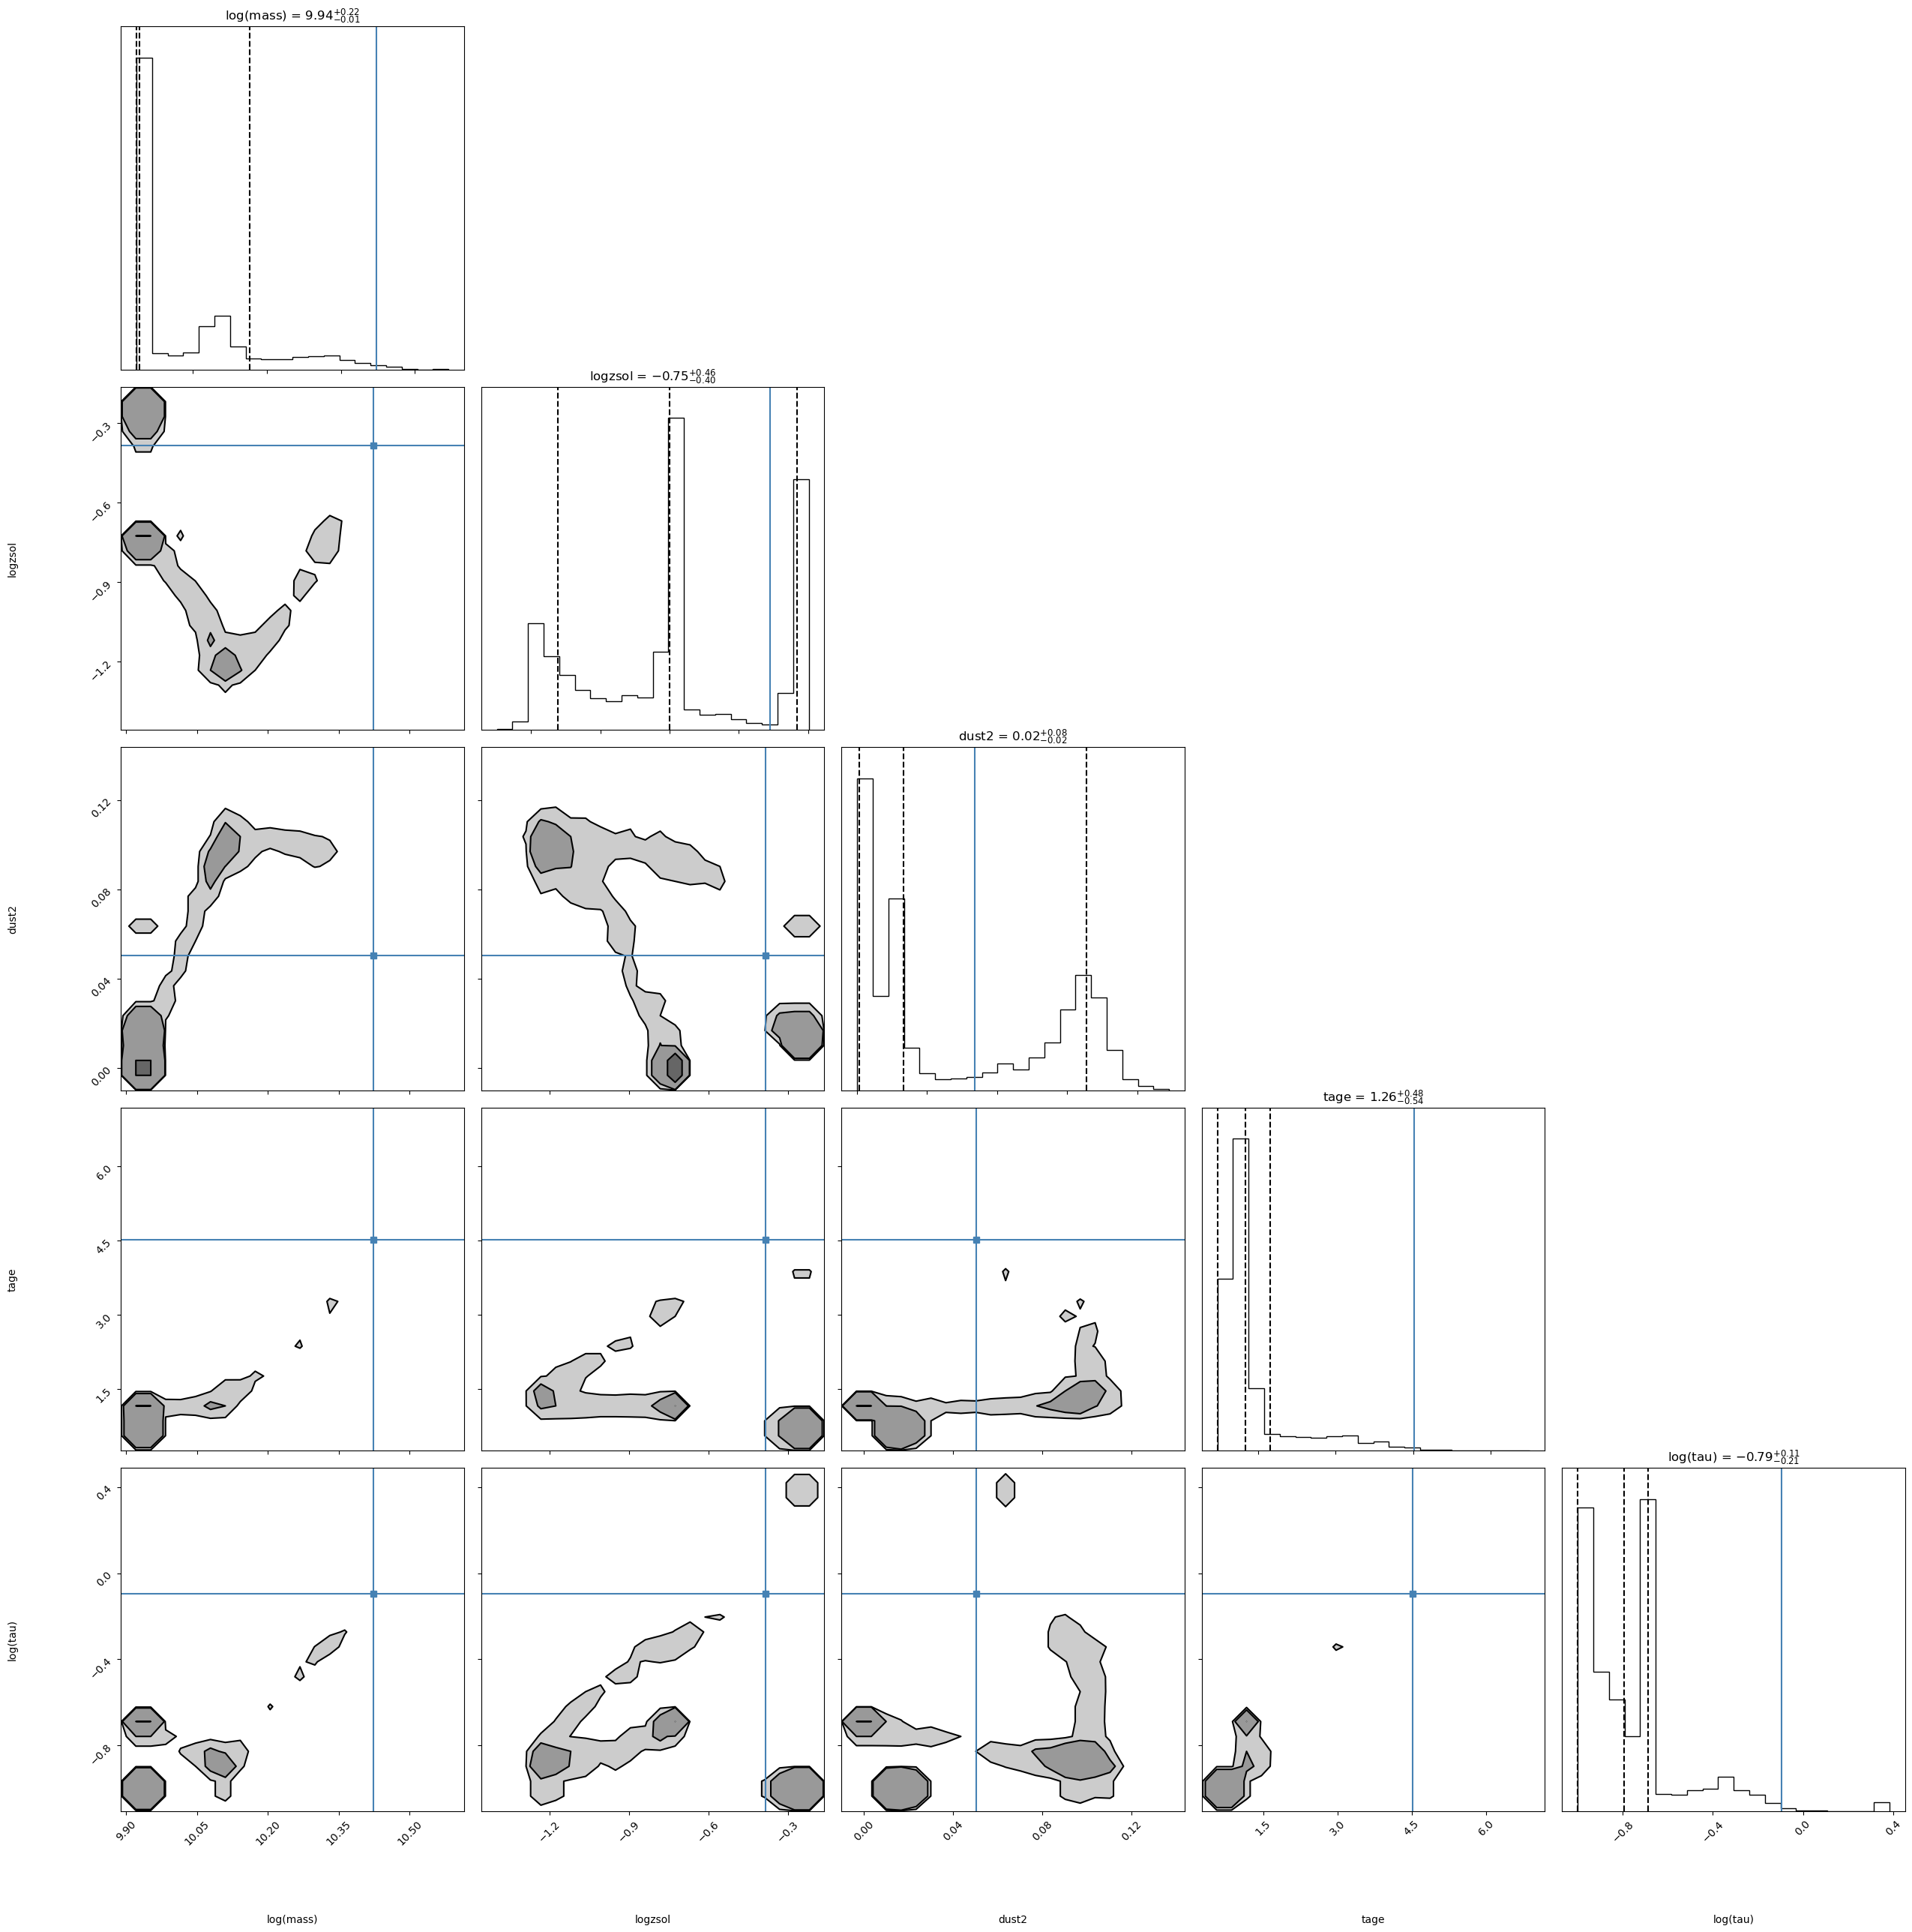

In [12]:

imax = np.argmax(result['lnprobability'])
if results_type == "emcee":
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    print(result['chain'][i, j, :].copy())
    theta_best = result['chain'][i, j, :].copy()
    thin = 5
else:
    theta_best = result["chain"][imax, :]
    thin = 1

print('Optimization value: {}'.format(theta_best))
print('MAP value: {}'.format(theta_best))
cornerfig = reader.subcorner(result, start=800, thin=thin, truths=theta_best, 
                             fig=plt.subplots(5,5,figsize=(27,27))[0])

In [13]:
imax = np.argmax(result['lnprobability'])
csz = result["chain"].shape
if result["chain"].ndim > 2:
    # emcee
    i, j = np.unravel_index(imax, result['lnprobability'].shape)
    theta_max = result['chain'][i, j, :].copy()
    flatchain = result["chain"].reshape(csz[0] * csz[1], csz[2])
else:
    # dynesty
    theta_max = result['chain'][imax, :].copy()
    flatchain = result["chain"]

# 16th, 50th, and 84th percentiles of the posterior
from prospect.plotting.corner import quantile
weights = result.get("weights", None)
post_pcts = quantile(flatchain.T, q=[0.16, 0.50, 0.84], weights=weights)

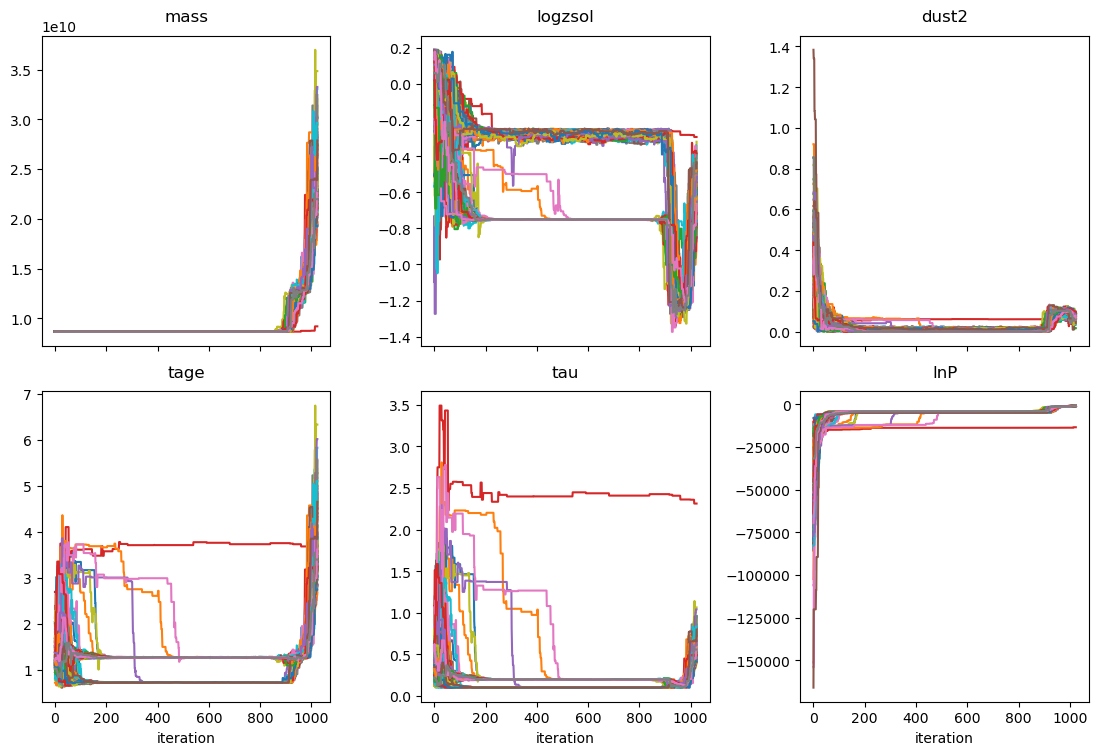

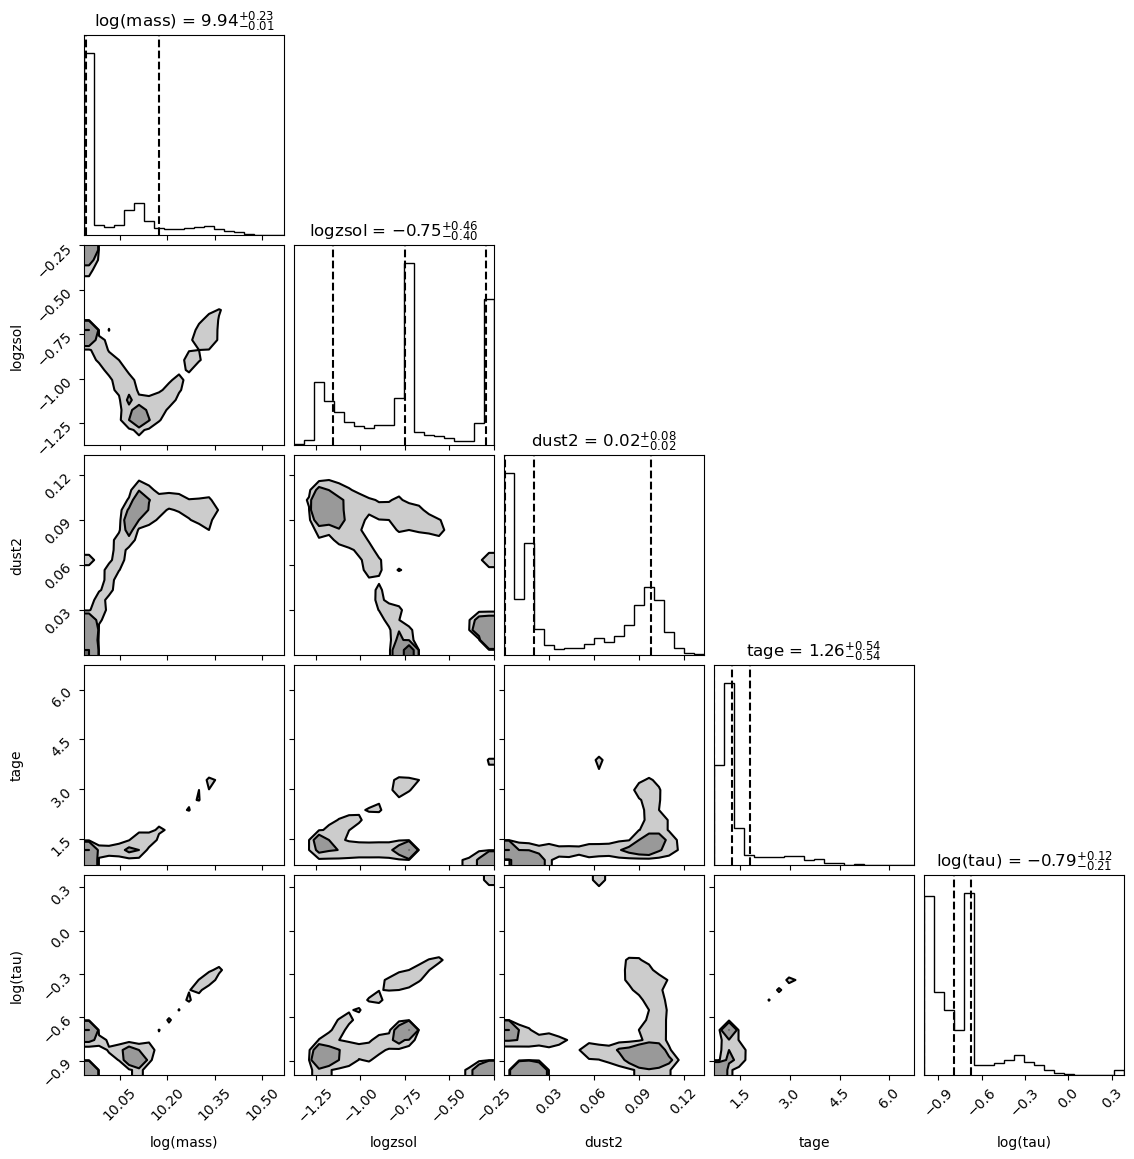

In [14]:
tfig = reader.traceplot(result)
# Corner figure of posterior PDFs
cfig = reader.subcorner(result,start=800)

Text(0, 0.5, '$\\chi_{\\rm best}$')

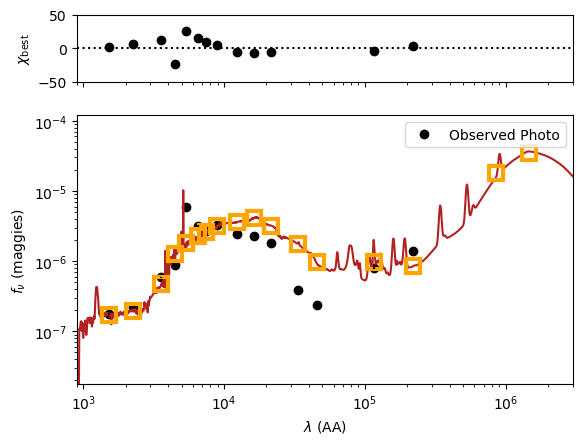

In [15]:
sfig, saxes = plt.subplots(2, 1, gridspec_kw=dict(height_ratios=[1, 4]), sharex=True)
ax = saxes[1]
pwave = np.array([f.wave_effective for f in out_obs["filters"]])
# plot the data
ax.plot(pwave, out_obs["maggies"], linestyle="", marker="o", color="k",label='Observed Photo')
#ax.plot(obs['wavelength'],obs['spectrum']*obs['wavelength'])
ax.errorbar(pwave,  out_obs["maggies"], out_obs["maggies_unc"], linestyle="", color="k", zorder=10)
ax.set_ylabel(r"$f_\nu$ (maggies)")
ax.set_xlabel(r"$\lambda$ (AA)")
ax.set_xlim(9e2, 3e6)
ax.set_ylim(np.nanmin(out_obs["maggies"]) * 0.1, np.nanmax(out_obs["maggies"]) * 20)
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

# get the best-fit SED
bsed = out["bestfit"]
ax.plot(bsed["restframe_wavelengths"] * (1+out_obs["redshift"]), bsed["spectrum"], color="firebrick", label="MAP sample")
ax.plot(pwave, bsed["photometry"], linestyle="", marker="s", markersize=10, mec="orange", mew=3, mfc="none")

ax = saxes[0]
chi = (out_obs["maggies"] - bsed["photometry"]) / out_obs["maggies_unc"]
ax.plot(pwave, chi, linestyle="", marker="o", color="k")
ax.axhline(0, color="k", linestyle=":")
ax.set_ylim(-50, 50)
ax.set_ylabel(r"$\chi_{\rm best}$")